<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '.'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
import math
from collections import Counter,OrderedDict

def load_pkl(fname):
    with open(os.path.join(PATH_TO_DATA, fname), 'rb') as pkl:
        return pickle.load(pkl)

def slice_with_nulls(df, i, session_length, window_size):
    inds = range(i*window_size, i*window_size+session_length 
                 if i*window_size+session_length < df.shape[0] 
                 else df.shape[0])
    diff = (pd.to_datetime(df['timestamp'].values[inds[1:]])-\
                               pd.to_datetime(df['timestamp'].values[inds[0:-1]])).seconds.values

    return np.concatenate((df['site'].values[inds], 
                            np.zeros([session_length - len(inds)]),
                            diff, 
                            np.zeros([session_length - 1 - len(inds[0:-1])]), 
                            (
                            sum(diff), 
                            df['site'].iloc[inds].nunique(), 
                            int(df['timestamp'].iloc[inds[0]][-8:-6]), 
                            pd.to_datetime(df['timestamp'].iloc[inds[0]]).weekday()
                            )
                                    ))
    
def get_file_sessions(fname, frequencies, session_length=10, window_size=10):
    df = pd.read_csv(fname, sep=',')
    user_id = int(os.path.basename(fname)[4:8])
    
    #n of rows   
    N = math.ceil(df.shape[0]/window_size)    
    sessions_rows = np.array([slice_with_nulls(df, i, session_length, window_size) for i in range(0,N)])\
                    .reshape(N,session_length*2-1+4)
#     print(sessions_rows)
    user_column = np.full((N,1), user_id)
    to_add = np.concatenate([sessions_rows, user_column], axis=1)

    return to_add

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    #загрузим частоты из первой части, не будем пересчитывать
    frequencies = load_pkl(site_freq_path)

    sessions = pd.DataFrame(np.concatenate([get_file_sessions(f, frequencies, session_length, window_size) for f 
                                            in glob(os.path.join(path_to_csv_files, '*.csv'))]))
#     display(sessions)
    sessions.columns = feature_names

    #replace site names with ids in sessions
    sessions = pd.concat([sessions.iloc[:, 0:session_length]
                          .apply(lambda col: col.apply(lambda el: 0 if el == 0 else frequencies[el][0])),
                         sessions.iloc[:, session_length:]], axis=1)#.apply(np.int64)
    
    return sessions
    
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)
train_data_10users.to_csv(os.path.join(PATH_TO_DATA, 
                                       'train_data_10users.csv'), 
                        index_label='session_id', float_format='%d')

Wall time: 20.8 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)
train_data_150users.to_csv(os.path.join(PATH_TO_DATA, 
                                       'train_data_150users.csv'), 
                        index_label='session_id', float_format='%d')

Wall time: 2min 48s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [11]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

In [17]:
train_data_10users['session_timespan'] = train_data_10users['session_timespan'].apply(int)

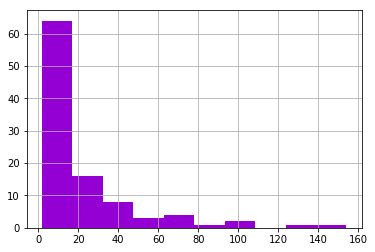

In [18]:
train_data_10users[train_data_10users['session_timespan']<=200]['session_timespan'][0:100].hist(color = 'darkviolet')

Text(0, 0.5, 'Количество')

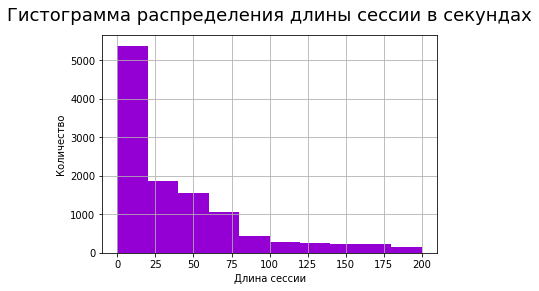

In [19]:
train_data_10users[train_data_10users['session_timespan']<=200]['session_timespan'].hist(color ='darkviolet')
plt.title('Гистограмма распределения длины сессии в секундах',x=0.5,y = 1.04, size= 18 )
plt.xlabel('Длина сессии')
plt.ylabel('Количество')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество')

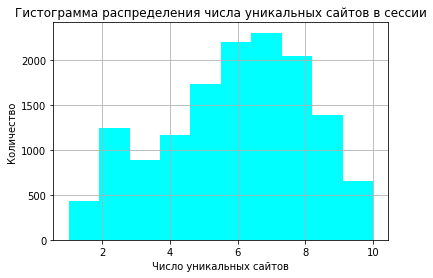

In [20]:
train_data_10users['#unique_sites'] = train_data_10users['#unique_sites'].apply(int)
train_data_10users['#unique_sites'].hist(color='aqua')
plt.title('Гистограмма распределения числа уникальных сайтов в сессии')
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Количество')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

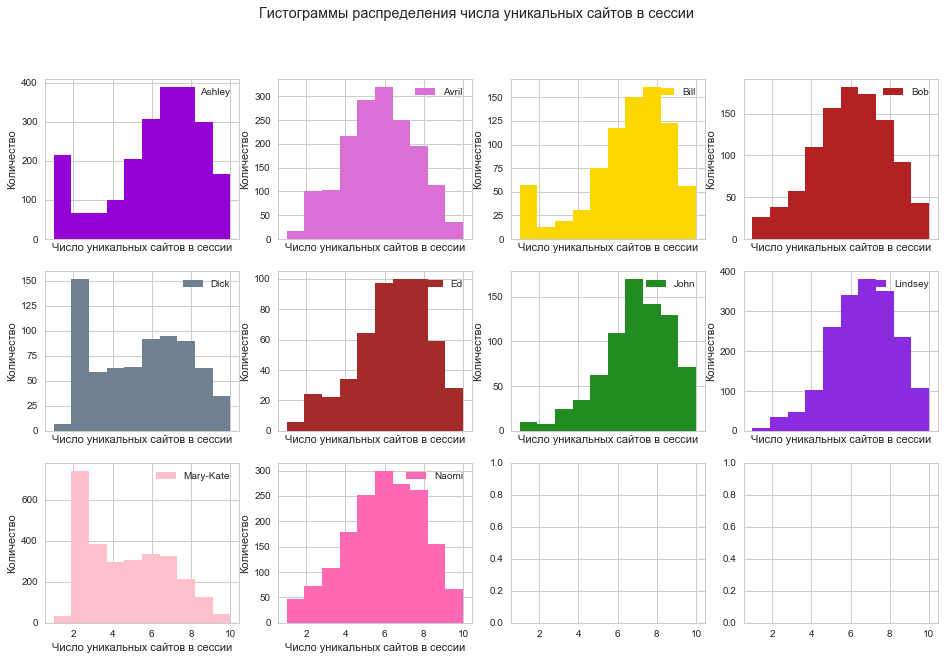

In [107]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True)#, sharey=True)
fig.suptitle('Гистограммы распределения числа уникальных сайтов в сессии')
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[int(idx/4), int(idx%4)]
    sub_df['#unique_sites'].hist(color=color_dic[user], ax = ax, label = user)
    ax.legend(loc='upper right')
    ax.set(xlabel='Число уникальных сайтов в сессии', ylabel = 'Количество')
    

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

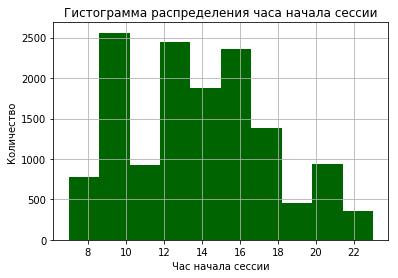

In [22]:
train_data_10users['start_hour'] = train_data_10users['start_hour'].apply(int)
plt.title('Гистограмма распределения часа начала сессии')
plt.xlabel('Час начала сессии')
plt.ylabel('Количество')
train_data_10users['start_hour'].hist(color='darkgreen')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

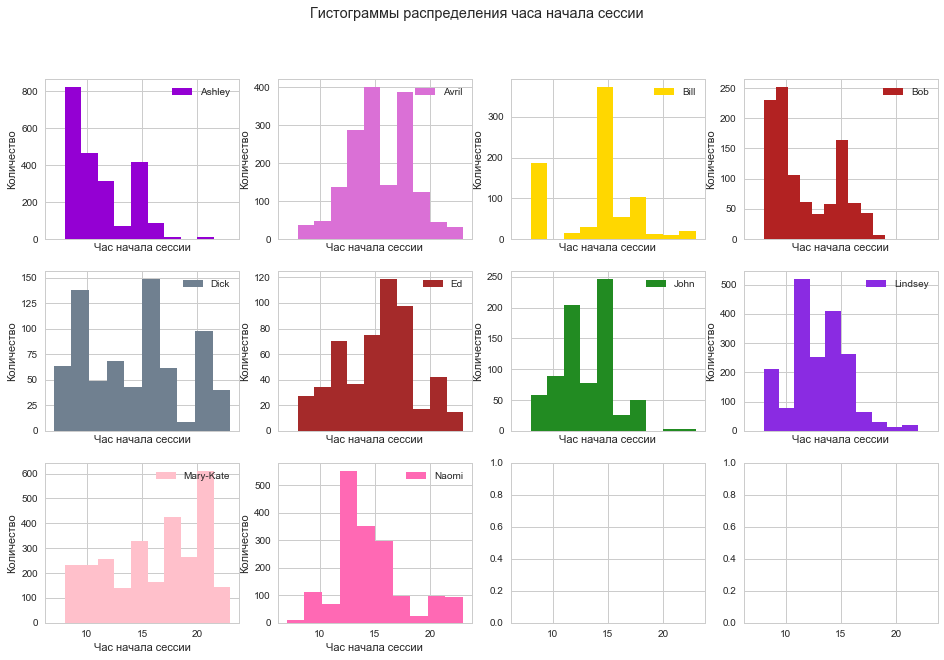

In [106]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True)#, sharey=True)
fig.suptitle('Гистограммы распределения часа начала сессии')
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[int(idx/4), int(idx%4)]
    sub_df['start_hour'].hist(color=color_dic[user], ax = ax, label = user)
    ax.legend(loc='upper right')
    ax.set(xlabel='Час начала сессии', ylabel = 'Количество')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

In [24]:
dow_name_dict = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница',
               5: 'Суббота', 6 : 'Воскресенье'}
dow_names = dow_name_dict.values()
train_data_10users['day_of_week'] = train_data_10users['day_of_week'].map(dow_name_dict)
dow_names

dict_values(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])

In [25]:
train_data_10users['day_of_week'].value_counts()
dow_name_dict.values()
train_data_10users['day_of_week'].values

array(['Пятница', 'Пятница', 'Пятница', ..., 'Среда', 'Среда', 'Среда'],
      dtype=object)

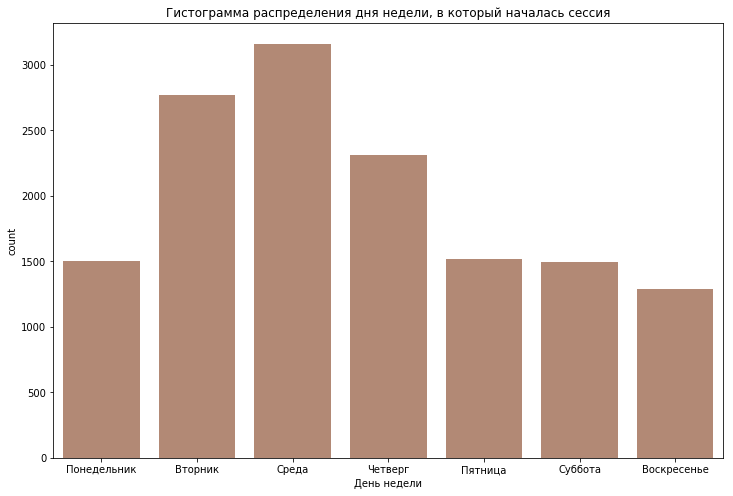

In [26]:
# train_data_10users['day_of_week']=train_data_10users['day_of_week'].apply(int)
plt.figure(figsize=(12,8))
plt.title('Гистограмма распределения дня недели, в который началась сессия')
plt.xlabel('День недели')
plt.ylabel('Количество')
# train_data_10users['day_of_week'].hist(color='sienna')
sns.countplot(x=train_data_10users['day_of_week'].values, alpha=0.7, color='sienna', order = dow_names ) 

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

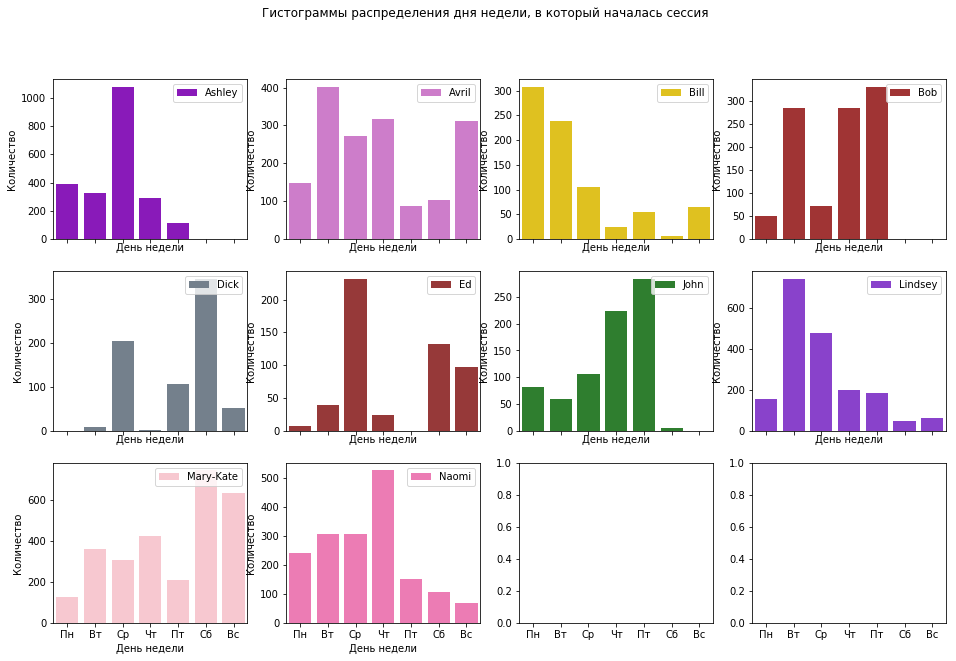

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex = True)#, sharey = True)
fig.suptitle('Гистограммы распределения дня недели, в который началась сессия')
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[int(idx/4), int(idx%4)]
    sns.countplot(x= sub_df['day_of_week'].values, color=color_dic[user], ax = ax, label = user, 
                  order = dow_names)
    ax.legend(loc='upper right')
    ax.set(xlabel='День недели', ylabel = 'Количество')
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Mary-Kate: скорее всего, есть два любимых сайта, чаще всего заходит по субботам вечером, реже всего - в понедельник, самый активный пользователь из 10, судя по площади гистограммы, отражающей число сессий (видно на первом графике с общими координатами по оси ординат)

Ashley: по выходным нет данных об использовании интернета, чаще всего серфит по средам, нет предпочитаемого количества сайтов в сессию, в сети чаще заполночь

Lindsey: часто в сети по вторникам, по выходным - отдыхает, в сети в основном в середине дня, сайтов в сессию чаще больше разных

Naomi: В сети несколько чаще по четвергам, реже по выходным, чаще в середине дня, по числу уникальных сайтов предпочтения выражены слабо, скорее больше уникальных, чем неуникальных

Avril: реже выходит в сеть по пятницам и субботам, в 14 и 17 часов наибольшая вероятность посещения, среднее число уникальных посещаемых сайтов - 6

Bob: по выходным нет данных о посещениях, чаще в сети с раннего утра и до 10ти, по числу уникальных сайтов предпочтения выражены слабо

Bill: Чаще в сети в начале недели, предпочтительно в 15 часов дня, по числу уникальных сайтов предпочтения выражены слабо

John: по выходным не бывает в сети, больше всего появляется в пятницу, в среднем чаще в середине дня, среднее число уникальных сайтов - 7

Dick: мало пользуется сетью, чаще по средам и субботам, реже всего выходит в 19-20 часов, чаще всего сессия из двух сайтов

Ed: меньше всех пользуется сетью, чаще всего по средам, в среднем - 6-7 уникальных сайтов в сессию, в основном в середине дня

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [28]:
freqs = load_pkl('site_freq_10users.pkl')
freqs

{'s.youtube.com': (1, 8300),
 'www.google.fr': (2, 7813),
 'www.google.com': (3, 5441),
 'mail.google.com': (4, 4158),
 'www.facebook.com': (5, 4141),
 'apis.google.com': (6, 3758),
 'r3---sn-gxo5uxg-jqbe.googlevideo.com': (7, 3244),
 'r1---sn-gxo5uxg-jqbe.googlevideo.com': (8, 3094),
 'plus.google.com': (9, 2630),
 'accounts.google.com': (10, 2089),
 'r2---sn-gxo5uxg-jqbe.googlevideo.com': (11, 1939),
 'fr-mg42.mail.yahoo.com': (12, 1868),
 'www.youtube.com': (13, 1804),
 'r4---sn-gxo5uxg-jqbe.googlevideo.com': (14, 1702),
 'clients1.google.com': (15, 1493),
 'download.jboss.org': (16, 1441),
 's-static.ak.facebook.com': (17, 1388),
 'static.ak.facebook.com': (18, 1265),
 'i1.ytimg.com': (19, 1232),
 'twitter.com': (20, 1204),
 'accounts.youtube.com': (21, 1057),
 'platform.twitter.com': (22, 1041),
 'clients6.google.com': (23, 1039),
 'safebrowsing-cache.google.com': (24, 1039),
 'translate.google.fr': (25, 1002),
 'api.twitter.com': (26, 982),
 'accounts.google.fr': (27, 974),
 'tal

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [84]:
from collections import Counter
counter = Counter(dict((k, v[1]) for k, v in freqs.items()))
top10_df = pd.DataFrame(counter.most_common(10))
top10_freqs = top10_df.iloc[:, 1]
top10_sites = top10_df.iloc[:, 0]

top30_site_ids = set([freqs[i][0] for i in pd.DataFrame(counter.most_common(30))[0]])
freq_df = pd.DataFrame(counter.most_common()).iloc[:,1]
index_least_popular = freq_df[freq_df == np.percentile(pd.DataFrame(counter.most_common()).iloc[:,1], 40)].index[0]
leastpopular_site_ids = set([freqs[i][0] for i in pd.DataFrame(counter.most_common()).iloc[index_least_popular:,0]])
len(leastpopular_site_ids)

2339

In [79]:
np.percentile?

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

Text(0, 0.5, 'Частоты')

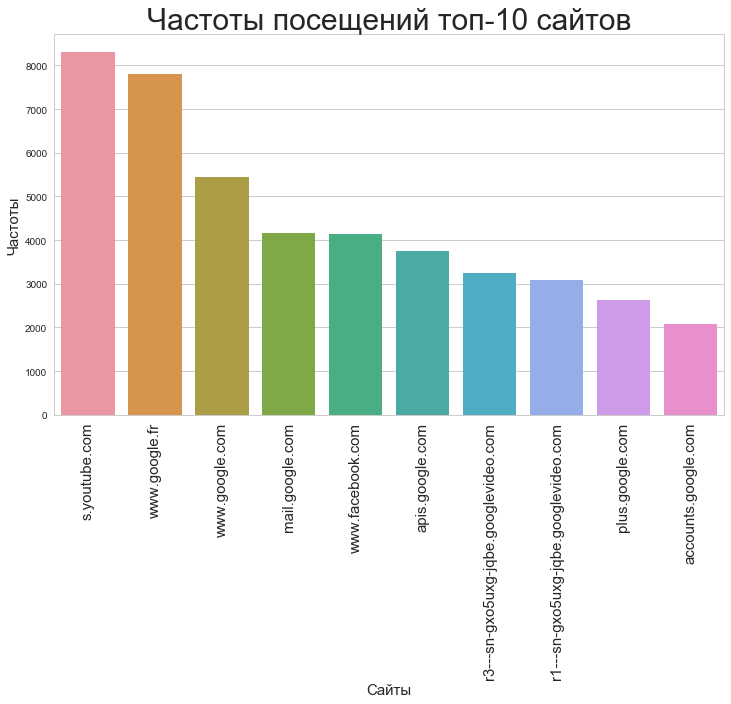

In [30]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,7))
plt.xticks(rotation="vertical",fontsize=15)
plt.title('Частоты посещений топ-10 сайтов',fontsize=30)
ax = sns.barplot(x=top10_sites, y = top10_freqs)
ax.set_xlabel("Сайты",fontsize=15)
ax.set_ylabel("Частоты",fontsize=15)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [116]:
def feature_engineering(path_to_train_data_nusers_csv, site_freq_path, session_length=10):
    frequencies = load_pkl(site_freq_path)
    train_data = pd.read_csv(path_to_train_data_nusers_csv, header = 0, index_col = 0)
    site_columns = ['site' + str(i) for i in range(1,session_length+1)]
    
    #среди уникальных сайтов в сессии - количество принадлежащих к top30
    train_data['number_of_top30'] = train_data.apply(lambda row: 
                                         len(set(row.loc[site_columns].apply(int).unique()) & top30_site_ids), axis = 1)
    
    train_data['number_of_least_popular'] = train_data.apply(lambda row: 
                                         len(set(row.loc[site_columns].apply(int).unique()) & leastpopular_site_ids), axis = 1)
#     display(train_data)
    return train_data
# feature_engineering('train_data_10users.csv', 'site_freq_10users.pkl', )

In [117]:
new_features_10users = feature_engineering('train_data_10users.csv', 'site_freq_10users.pkl', )
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [87]:
new_features_150users = feature_engineering('train_data_150users.csv', 'site_freq_150users.pkl', )

In [88]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

[Text(0, 0.5, 'Количество'),
 Text(0.5, 0, 'Число уникальных сайтов сессии из наименее популярных')]

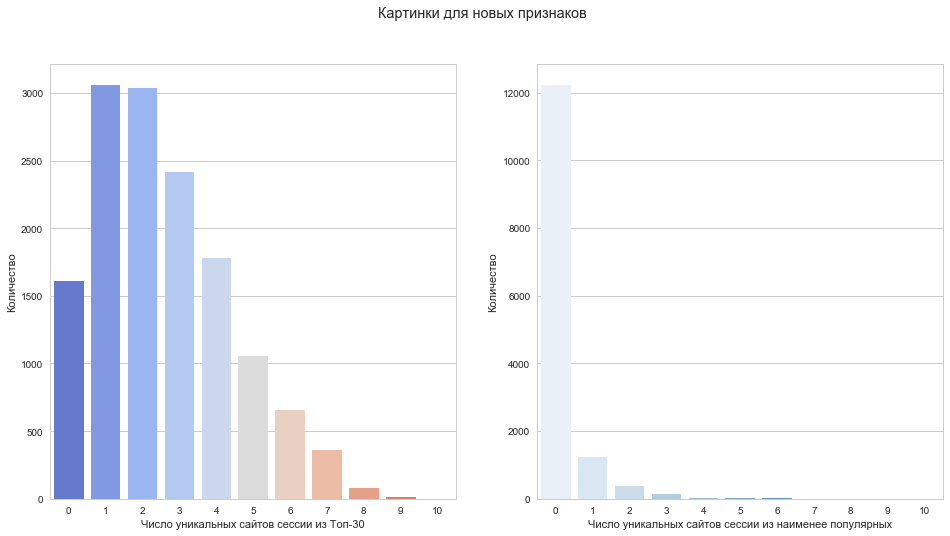

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))#, sharex = True, sharey = True)
fig.suptitle('Картинки для новых признаков')

ax = axes[0]
sns.countplot(x= new_features_10users['number_of_top30'].values, palette="coolwarm", ax = ax,) 
ax.set(xlabel='Число уникальных сайтов сессии из Топ-30', ylabel = 'Количество')

ax = axes[1]
sns.countplot(x= new_features_10users['number_of_least_popular'].values, palette="Blues", ax = ax,) 
ax.set(xlabel='Число уникальных сайтов сессии из наименее популярных', ylabel = 'Количество')

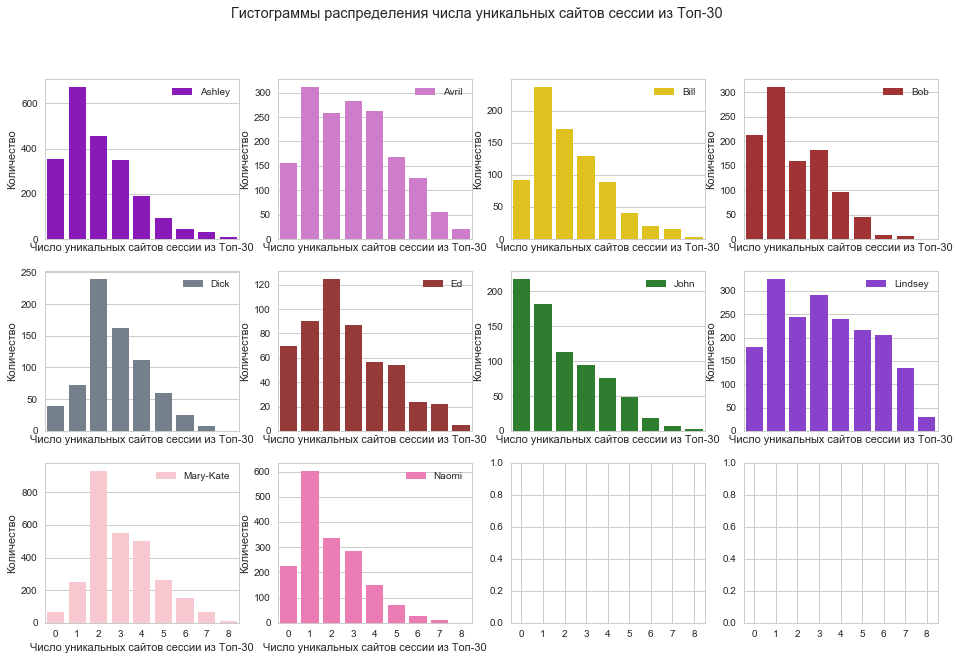

In [119]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex = True)#, sharey = True)
fig.suptitle('Гистограммы распределения числа уникальных сайтов сессии из Топ-30')

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = axes[int(idx/4), int(idx%4)]
    sns.countplot(x= sub_df['number_of_top30'].values, color=color_dic[user], ax = ax, label = user)
    ax.legend(loc='upper right')
    ax.set(xlabel='Число уникальных сайтов сессии из Топ-30', ylabel = 'Количество')

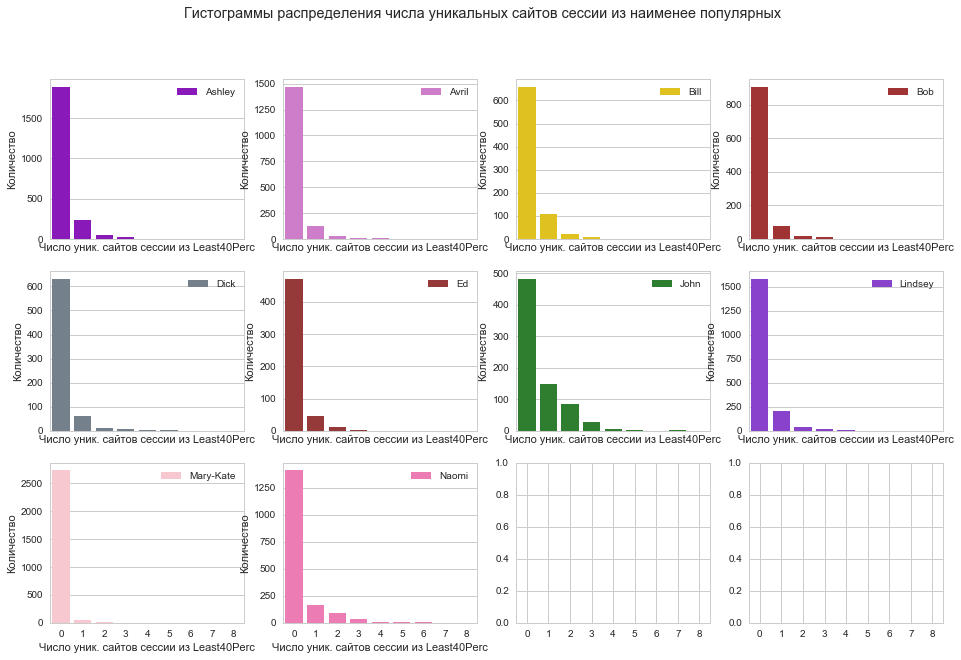

In [128]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex = True)#, sharey = True)
fig.suptitle('Гистограммы распределения числа уникальных сайтов сессии из наименее популярных')

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = axes[int(idx/4), int(idx%4)]
    sns.countplot(x= sub_df['number_of_least_popular'].values, color=color_dic[user], ax = ax, label = user)
    ax.legend(loc='upper right')
    ax.set(xlabel='Число уник. сайтов сессии из Least40Perc', ylabel = 'Количество')

Как видим, для новых признаков распределения тоже различаются: кто-то совсем не ходит на редкие сайты, а у кого-то и по 2, и по 3 в сессии бывает; по Топ-30 видим, что Lindsey и Avril ходят почти только на популяные сайты.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [129]:
selected_features_10users = new_features_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'number_of_least_popular', 'number_of_top30']] 
selected_features_150users = new_features_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'number_of_least_popular', 'number_of_top30']] 

In [130]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 